In [1]:
import os

os.chdir("../")

print(os.getcwd())

c:\Users\mnnadi1\Desktop\Generative AI\New folder\Generative_AI_surfactants_molecules


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from logging import getLogger

from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from chainer_chemistry.saliency.visualizer.base_visualizer import BaseVisualizer
from chainer_chemistry.saliency.visualizer.visualizer_utils import red_blue_cmap, abs_max_scaler

from src.GraphWisconsin.generate_graph_dataset import graph_dataset
from src.GraphWisconsin.model_GNN import GCNReg

In [4]:
class SaliencyVisualizer:
    
    def __init__(self, model_path, model_name, data_path):
        self.model = self._load_model(model_path, model_name)
        self.data_path = data_path

    @staticmethod
    def _load_model(model_path, model_name):
        checkpoint = torch.load(f"{model_path}/{model_name}")
        model = GCNReg(74, 256, 1, True)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model

    def visualize_saliency(self, file_path='./reports/saliency_R2'):
        dat = pd.read_csv(self.data_path, header=None)
        sml_exp = dat[0].to_list()
        logCMC = [0] * len(sml_exp)

        g_exp = graph_dataset(sml_exp, logCMC)

        for test_id in range(len(sml_exp)):
            sml = sml_exp[test_id]
            cmc = logCMC[test_id]
            test_g = g_exp[test_id][0]
            n_feat = test_g.ndata['h'].numpy()
            pred, grad = self.model(test_g)
            pred = pred.cpu().detach().numpy().flatten()[0]
            n_sal = grad.cpu().detach().numpy()
            n_sal_sum_atom = np.sum(n_sal[:, 0:43] * n_feat[:, 0:43], axis=1)

            visualizer = SmilesVisualizer()
            scaler = abs_max_scaler
            svg, _ = visualizer.visualize(
                n_sal_sum_atom, sml,
                save_filepath=f"{file_path}/actualdata_row_{str(test_id + 1).zfill(3)}.png",
                visualize_ratio=1, bond_color=False, scaler=scaler,
                legend=f"{sml}, pred:{pred:.2f}"
            )
            # Uncomment the next line if you want to display the SVG inline (e.g., in Jupyter)
            #display(SVG(svg.replace('svg:', '')))
            #save_filepath=f"{file_path}/actualdata_row_{str(test_id + 1).zfill(3)}.png"


if __name__ == "__main__":
    model_path = ".//models"
    model_name = "GCN_early_stop//ep1000bs5lr0.005kf11hu256cvid5es.pth.tar"
    data_path = ".//data//test_more_dataNoinionc.csv                                                                         "
    
    visualizer = SaliencyVisualizer(model_path, model_name, data_path)
    visualizer.visualize_saliency(file_path='.')


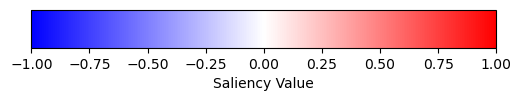

In [5]:
import matplotlib.pyplot as plt

def plot_colorbar(cmap_name='bwr'):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    # Create a colormap
    cmap = plt.get_cmap(cmap_name)

    # Create a colorbar with custom settings
    norm = plt.Normalize(-1, 1)  # Assuming your saliency values range from -1 to 1
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation='horizontal')
    cbar.set_label('Saliency Value')
    plt.show()

plot_colorbar('bwr')


In [6]:
print(os.getcwd())

c:\Users\mnnadi1\Desktop\Generative AI\New folder\Generative_AI_surfactants_molecules
